## Resume Classification
### Business objective:
* **The document classification solution should significantly reduce the manual human effort in the HRM. It should achieve a higher level of accuracy and automation with minimal human intervention**

## 1. Import Library

In [61]:
import os
import glob
from pathlib import Path
import spacy
import docx2txt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

## 2. About Dataset

In [62]:
all_files = glob.glob("Resumes_Docx/*/*")
all_files = [f.replace("\\", "/") for f in all_files]

In [63]:
df = pd.DataFrame({"path": all_files})
df["folder"] = df["path"].apply(lambda x: Path(x).parent.name)
df["ext"]    = df["path"].apply(lambda x: Path(x).suffix.replace(".", "").lower())
df

,path,folder,ext
0,Resumes_Docx/Peoplesoft/Peoplesoft Admin_G Ana...,Peoplesoft,docx
1,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx
2,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,doc
3,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,doc
4,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx
...,...,...,...
75,Resumes_Docx/workday/Sri Krishna S_Hexaware.doc,workday,doc
76,Resumes_Docx/workday/Srikanth-Hexaware.docx,workday,docx
77,Resumes_Docx/workday/SSKumar_Hexaware.docx,workday,docx
78,Resumes_Docx/workday/Venkateswarlu B_Hexaware.doc,workday,doc


### 2.1 Type of Table Format

In [64]:
folder_ext_counts = df.groupby(["folder", "ext"]).size().reset_index(name="count").sort_values(by=["folder", "ext"])
folder_ext_counts.index = folder_ext_counts.index + 1
folder_ext_counts

,folder,ext,count
1,Peoplesoft,docx,1
2,Peoplesoft Resume,doc,10
3,Peoplesoft Resume,docx,10
4,React Developer,doc,3
5,React Developer,docx,20
6,React Developer,pdf,1
7,SQL Developer,doc,3
8,SQL Developer,docx,11
9,workday,doc,10
10,workday,docx,11


In [65]:
pivot_df = df.pivot_table(index="folder", columns="ext", aggfunc="size", fill_value=0)
pivot_df = pivot_df[pivot_df.sum(axis=1) != 0]
pivot_df

ext,doc,docx,pdf
folder,,,
Peoplesoft,0,1,0
Peoplesoft Resume,10,10,0
React Developer,3,20,1
SQL Developer,3,11,0
workday,10,11,0


### 3.1 Type of Folder vs File Count

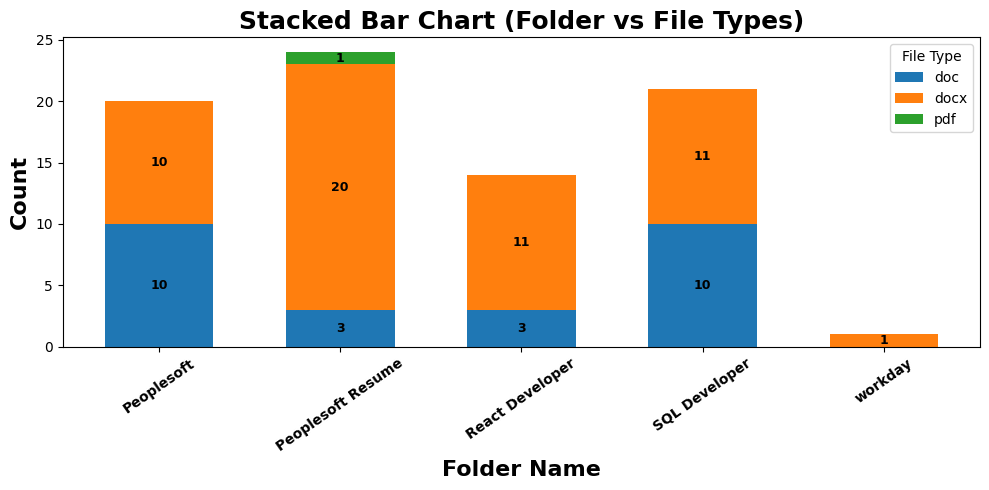

In [66]:
x = np.arange(len(pivot_df.index))
width = 0.6
fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(len(pivot_df.index))
for i, ext in enumerate(pivot_df.columns):
    values = pivot_df[ext].values
    mask = values > 0
    if not np.any(mask):
        continue
    p = ax.bar(pivot_df.index[mask], values[mask], width, label=ext, bottom=bottom[mask],)
    for rect, v in zip(p, values[mask]):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + rect.get_height() / 2, f"{v}",
                ha='center', va='center',fontsize=9, fontweight='bold')
    bottom[mask] += values[mask]
ax.set_xlabel("Folder Name", size=16, fontweight='bold')
ax.set_ylabel("Count", size=16, fontweight='bold')
ax.set_title("Stacked Bar Chart (Folder vs File Types)", fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index, rotation=35,fontweight='bold')
ax.legend(title="File Type")
plt.tight_layout()
plt.show()

In [67]:
folder_ext_counts = df.groupby("ext").size().reset_index(name="count")
folder_ext_counts.index = folder_ext_counts.index + 1
folder_ext_counts

,ext,count
1,doc,26
2,docx,53
3,pdf,1


In [68]:
total_count = folder_ext_counts["count"].sum()

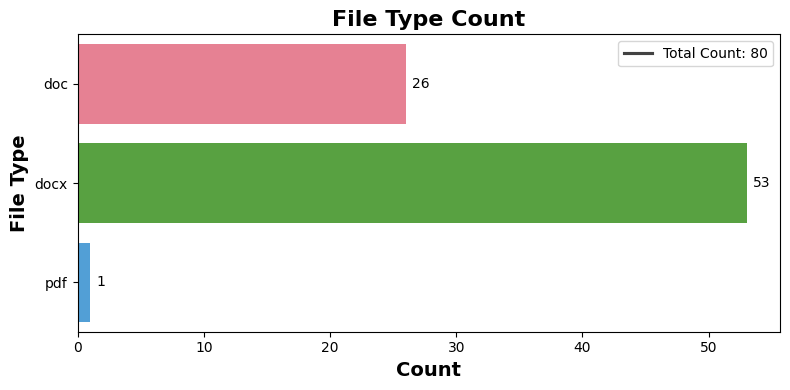

In [69]:
plt.figure(figsize=(8, 4))
palette = sns.color_palette("husl", len(folder_ext_counts))
ax = sns.barplot(data=folder_ext_counts,x="count",y="ext",orient="h",palette=palette)
for index, value in enumerate(folder_ext_counts["count"]):
    ax.text(value + 0.5,index, str(value), va='center', fontsize=10,)
plt.xlabel("Count", fontsize=14, fontweight="bold")
plt.ylabel("File Type", fontsize=14, fontweight="bold")
plt.title("File Type Count", fontsize=16, fontweight="bold")
ax.legend([f"Total Count: {total_count}"],loc="upper right",frameon=True)
plt.tight_layout()
plt.show()


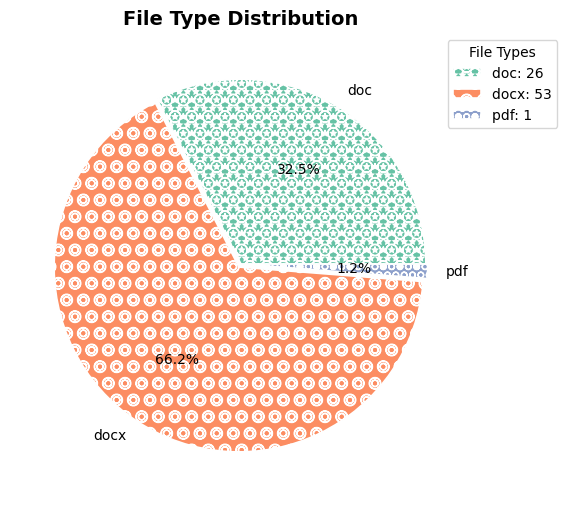

In [70]:
plt.figure(figsize=(6, 6))
colors = sns.color_palette('Set2')
explode = (0.00, 0.02, 0.01)
wedges, texts, autotexts =plt.pie(folder_ext_counts["count"], labels=folder_ext_counts["ext"],hatch=['**O', 'oO', 'O.O', '.||.'], 
    autopct="%1.1f%%", colors=colors, explode= explode,wedgeprops=dict(edgecolor="white", linewidth=1.2))
plt.legend(
    wedges,
    [f"{ext}: {cnt}" for ext, cnt in zip(folder_ext_counts["ext"], folder_ext_counts["count"])],
    title="File Types",
    loc="upper right",
    bbox_to_anchor=(1.2, 1)
)

plt.title("File Type Distribution", fontsize=14, fontweight="bold")
plt.show()

## 3. Extract Resumes by Profile Category

In [71]:
resume_data = df.groupby("folder").size().reset_index(name="count")
resume_data = resume_data.rename(columns={"folder": "Profile"})
resume_data.index = resume_data.index + 1
resume_data

,Profile,count
1,Peoplesoft,1
2,Peoplesoft Resume,20
3,React Developer,24
4,SQL Developer,14
5,workday,21


### 3.1 Percentage of Profiles Category¶

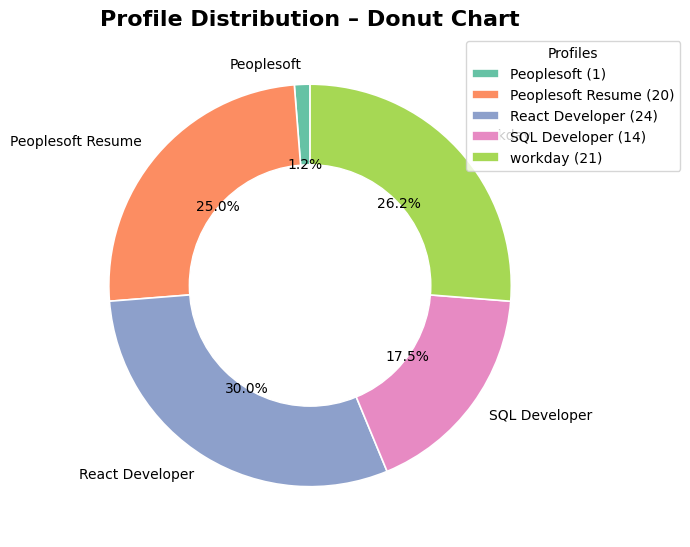

In [72]:
colors = sns.color_palette("Set2", len(resume_data))
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(resume_data["count"],labels=resume_data["Profile"],autopct="%1.1f%%",startangle=90,
    colors=colors,wedgeprops={"edgecolor": "white", "linewidth": 1.2})
centre_circle = plt.Circle((0, 0), 0.60, color='white')
plt.legend(wedges, [f"{p} ({c})" for p, c in zip(resume_data["Profile"], resume_data["count"])],
    title="Profiles",loc="upper right",bbox_to_anchor=(1.25, 1))
plt.gca().add_artist(centre_circle)
plt.title("Profile Distribution – Donut Chart", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

#### 3.2 Number of Total Resumes

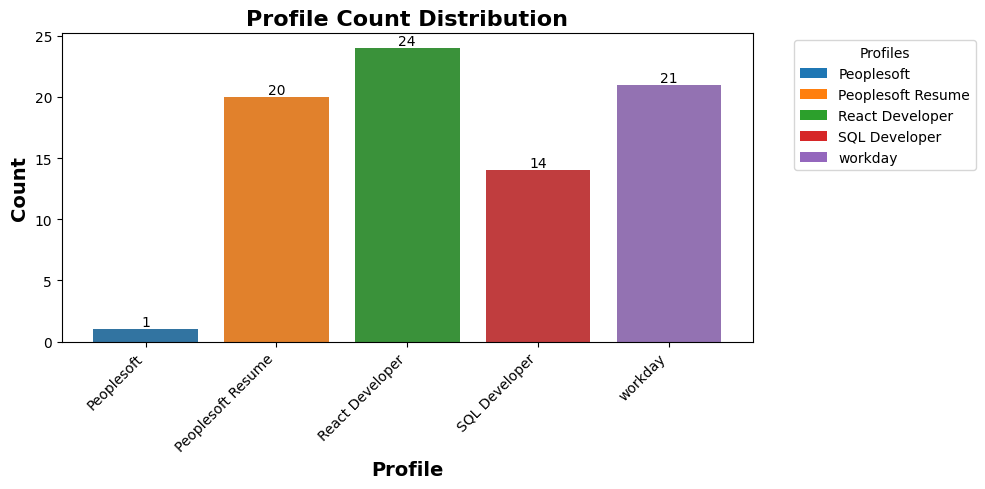

In [77]:
plt.figure(figsize=(10,5))
palette = sns.color_palette("tab10", len(resume_data))
ax = sns.barplot(data=resume_data, x="Profile", y="count", palette=palette)
for i, row in resume_data.iterrows():
    ax.text(i-1, row['count'], row['count'], ha='center', va='bottom')
for i, profile in enumerate(resume_data["Profile"]):
    plt.bar(0, 0, color=palette[i], label=profile)
plt.legend(title="Profiles", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Profile Count Distribution",fontsize=16, fontweight="bold")
plt.xlabel("Profile", fontsize=14, fontweight="bold")
plt.ylabel("Count", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Reading a Resume File

In [87]:
!pip install pypandoc

In [88]:
# import docx2txt
# from docx import Document
from PyPDF2 import PdfReader

# import zipfiledoc = docx.Document(filepath)
# from bs4 import BeautifulSoup
# import textract
import subprocess
import mammoth
from docx import Document
import pypandoc


In [98]:
def read_file(file_path):
    try:
        if file_path.endswith(".docx"):
            doc = Document(file_path)
            text = "\n".join([p.text for p in doc.paragraphs])
            return text
        if file_path.endswith(".pdf"):
            reader = PdfReader(file_path)
            return "\n".join(page.extract_text() or "" for page in reader.pages)
        if file_path.endswith(".doc"):
             with open(path, "rb") as f:
                result = mammoth.extract_raw_text(f)
                return result.value
    except:
        pass


In [99]:
df["text"] = df["path"].apply(read_file)
df

,path,folder,ext,text
0,Resumes_Docx/Peoplesoft/Peoplesoft Admin_G Ana...,Peoplesoft,docx,None
1,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Anubhav Kumar Singh\t\t\n\n To work in a gl...
2,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,doc,None
3,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,doc,None
4,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Murali\n\nExperience Summary \n\nI have 6 year...
...,...,...,...,...
75,Resumes_Docx/workday/Sri Krishna S_Hexaware.doc,workday,doc,None
76,Resumes_Docx/workday/Srikanth-Hexaware.docx,workday,docx,Seeking suitable positions in Workday HCM as ...
77,Resumes_Docx/workday/SSKumar_Hexaware.docx,workday,docx,\nWORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nR...
78,Resumes_Docx/workday/Venkateswarlu B_Hexaware.doc,workday,doc,None


In [100]:
resume_data = df[df["text"].notna() & (df["text"] != "")].reset_index(drop=True)
resume_data

,path,folder,ext,text
0,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Anubhav Kumar Singh\t\t\n\n To work in a gl...
1,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Murali\n\nExperience Summary \n\nI have 6 year...
2,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,\n\n\n\n\n\n\n\n\n\n\n\n\n\nPROFILE SUMMARY\n\...
3,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,PeopleSoft Admin\nVARKALA VIKAS\n\nCareer Obj...
4,Resumes_Docx/Peoplesoft Resume/PeopleSoft DBA_...,Peoplesoft Resume,docx,PeopleSoft Administration\n \nVivekanand Sayan...
5,Resumes_Docx/Peoplesoft Resume/Peoplesoft FSCM...,Peoplesoft Resume,docx,\nHaving 4.6 years of experience in PeopleSoft...
6,Resumes_Docx/Peoplesoft Resume/Peoplesoft FSCM...,Peoplesoft Resume,docx,\nHaving 4.6 years of experience in PeopleSoft...
7,Resumes_Docx/Peoplesoft Resume/Peoplesoft FSCM...,Peoplesoft Resume,docx,\n\nCAREER OBJECTIVE\t\t\n\nPursuing Peopleso...
8,Resumes_Docx/Peoplesoft Resume/Peoplesoft FSCM...,Peoplesoft Resume,docx,Tanna Sujatha \n\n\n\nOBJECTIVE\nSeeking a cha...
9,Resumes_Docx/Peoplesoft Resume/Resume_Subha Sa...,Peoplesoft Resume,docx,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nC O N ...


In [101]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
resume_data['Word_Count'] = resume_data['text'].apply(lambda x: len(str(x).split(" ")))
resume_data['Char_Count'] = resume_data['text'].str.len() 
resume_data['Stopwords'] = resume_data['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
resume_data['Numerics'] = resume_data['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
resume_data[['text','Word_Count','Char_Count','Stopwords','Numerics']].head()

,text,Word_Count,Char_Count,Stopwords,Numerics
0,Anubhav Kumar Singh\t\t\n\n To work in a gl...,978,7256,187,3
1,Murali\n\nExperience Summary \n\nI have 6 year...,494,3981,111,1
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\nPROFILE SUMMARY\n\...,451,3646,86,15
3,PeopleSoft Admin\nVARKALA VIKAS\n\nCareer Obj...,881,7265,224,3
4,PeopleSoft Administration\n \nVivekanand Sayan...,2508,15339,519,16


In [102]:
import re
from nltk.tokenize import RegexpTokenizer

In [103]:
def preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]

    return " ".join(filtered_words)

In [104]:
resume_data['Resume_Details'] = resume_data.text.apply(lambda x: preprocess(x))
resume_data['Resume_Details'].head()

0    anubhav kumar singh work globally competitive ...
1    murali experience summary years experience wor...
2    profile summary overall years experience peopl...
3    peoplesoft admin varkala vikas career objectiv...
4    peoplesoft administration vivekanand sayana ca...
Name: Resume_Details, dtype: object

In [105]:
resume_data.Resume_Details[0]

'anubhav kumar singh work globally competitive environment challenging assignments shall yield twin benefits job satisfaction steady paced professional growth professional experience current hcl current role system admin offshore skills shell scripting linux peoplesoft administration github managing peoplesoft hcm peoplesoft fscm production environments along support environments installed linux windows involved day day activities project migration database refresh system admin changes tax updates etc troubleshooting various servers like application servers web servers process scheduler servers applying tuxedo weblogic middleware cpu patches various applications working shell scripting used integration method exchange files external systems installation troubleshooting tier setup per requirement reviewing vulnerabilities reported security teams renewal ssl weblogic vulnerability remediation whenever vulnerability report rmis team worked pum peoplesoft update manager installation dpk wo

In [106]:
import nltk
import string

In [107]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = resume_data['Resume_Details'].values
cleanedSentences = ""
for records in Sentences:
    cleanedText = preprocess(records)
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('experience', 313), ('using', 247), ('workday', 194), ('application', 187), ('sql', 178), ('project', 177), ('server', 168), ('data', 167), ('reports', 164), ('peoplesoft', 156), ('business', 156), ('knowledge', 130), ('web', 125), ('process', 120), ('react', 119), ('good', 103), ('skills', 102), ('involved', 99), ('client', 98), ('system', 97), ('like', 96), ('working', 96), ('various', 95), ('creating', 94), ('worked', 92), ('support', 91), ('development', 91), ('integrations', 90), ('database', 86), ('tools', 84), ('technical', 84), ('servers', 83), ('developer', 83), ('integration', 81), ('design', 79), ('hcm', 78), ('created', 76), ('used', 74), ('report', 74), ('team', 71), ('people', 71), ('services', 71), ('html', 71), ('work', 70), ('testing', 69), ('responsibilities', 68), ('new', 66), ('custom', 66), ('role', 65), ('user', 64)]


In [108]:
nlp = spacy.load('en_core_web_lg')
one_block = cleanedSentences[1300:5200]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block, style= 'ent', jupyter= True)

In [109]:
for token in doc_block[:30]:
    print(token,token.pos_)  

upgrade VERB
project NOUN
migration NOUN
applications NOUN
ntt PROPN
cloud PROPN
premises NOUN
aws PROPN
cloud PROPN
worked VERB
shell NOUN
scripting NOUN
various ADJ
application NOUN
requirement NOUN
working VERB
ansible PROPN
jenkins PROPN
automated VERB
start PROPN
stop VERB
various ADJ
activities NOUN
application VERB
basic ADJ
knowledge NOUN
docker NOUN
applying VERB
ssl PROPN
certificates NOUN


In [110]:
one_block = cleanedSentences
doc_block = nlp(one_block)
nouns_verbs = [token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[:250])

['work', 'environment', 'challenging', 'assignments', 'yield', 'benefits', 'job', 'satisfaction', 'paced', 'growth', 'experience', 'role', 'system', 'admin', 'skills', 'shell', 'scripting', 'managing', 'fscm', 'production', 'environments', 'support', 'environments', 'installed', 'windows', 'involved', 'day', 'day', 'activities', 'project', 'migration', 'database', 'refresh', 'system', 'admin', 'changes', 'tax', 'updates', 'troubleshooting', 'servers', 'application', 'servers', 'web', 'servers', 'process', 'scheduler', 'servers', 'applying', 'tuxedo', 'weblogic', 'middleware', 'cpu', 'patches', 'applications', 'working', 'shell', 'scripting', 'used', 'integration', 'method', 'exchange', 'files', 'systems', 'installation', 'troubleshooting', 'tier', 'setup', 'requirement', 'reviewing', 'vulnerabilities', 'reported', 'security', 'teams', 'renewal', 'weblogic', 'vulnerability', 'remediation', 'vulnerability', 'report', 'team', 'worked', 'update', 'manager', 'installation', 'working', 'know

In [111]:
cv = CountVectorizer()
X = cv.fit_transform(nouns_verbs)
sum_words = X.sum(axis=0)

words_freq = [(word,sum_words[0,idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df = pd.DataFrame(words_freq)
wd_df.columns = ['Words','Count']
wd_df[0:15]

,Words,Count
0,experience,285
1,using,246
2,application,186
3,project,167
4,reports,164
5,data,159
6,business,149
7,workday,147
8,web,125
9,process,119


### 5.1 N-grams
* **N-grams analyses are often used to see which words often show up together.**

In [115]:
TextBlob(resume_data['Resume_Details'][1]).ngrams(3)[:20]

[WordList(['murali', 'experience', 'summary']),
 WordList(['experience', 'summary', 'years']),
 WordList(['summary', 'years', 'experience']),
 WordList(['years', 'experience', 'working']),
 WordList(['experience', 'working', 'peoplesoft']),
 WordList(['working', 'peoplesoft', 'administration']),
 WordList(['peoplesoft', 'administration', 'performing']),
 WordList(['administration', 'performing', 'various']),
 WordList(['performing', 'various', 'infrastructure']),
 WordList(['various', 'infrastructure', 'related']),
 WordList(['infrastructure', 'related', 'activities']),
 WordList(['related', 'activities', 'peoplesoft']),
 WordList(['activities', 'peoplesoft', 'environments']),
 WordList(['peoplesoft', 'environments', 'installed']),
 WordList(['environments', 'installed', 'configured']),
 WordList(['installed', 'configured', 'peoplesoft']),
 WordList(['configured', 'peoplesoft', 'web']),
 WordList(['peoplesoft', 'web', 'server']),
 WordList(['web', 'server', 'application']),
 WordList([

In [55]:
resume_data['Resume_Details']

0    page name prabakaran title developer professio...
Name: Resume_Details, dtype: object

### 5.2 Top 20 most used words in Resumes
* **Using CountVectorizer**

In [56]:
countvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2))
ngrams = countvec.fit_transform(resume_data['Resume_Details']) 
count_values = ngrams.toarray().sum(axis=0) 

vocab = countvec.vocabulary_ 
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k, i in vocab.items()],
                               reverse=True)).rename(columns={0: 'Frequency', 1:'Unigram_Bigram'})

In [57]:
df_ngram.head(20)

,Frequency,Unigram_Bigram
0,9,project
1,6,using
2,6,role
3,5,developer
4,5,android
5,4,technology
6,4,team
7,4,services
8,4,requirement
9,4,experience


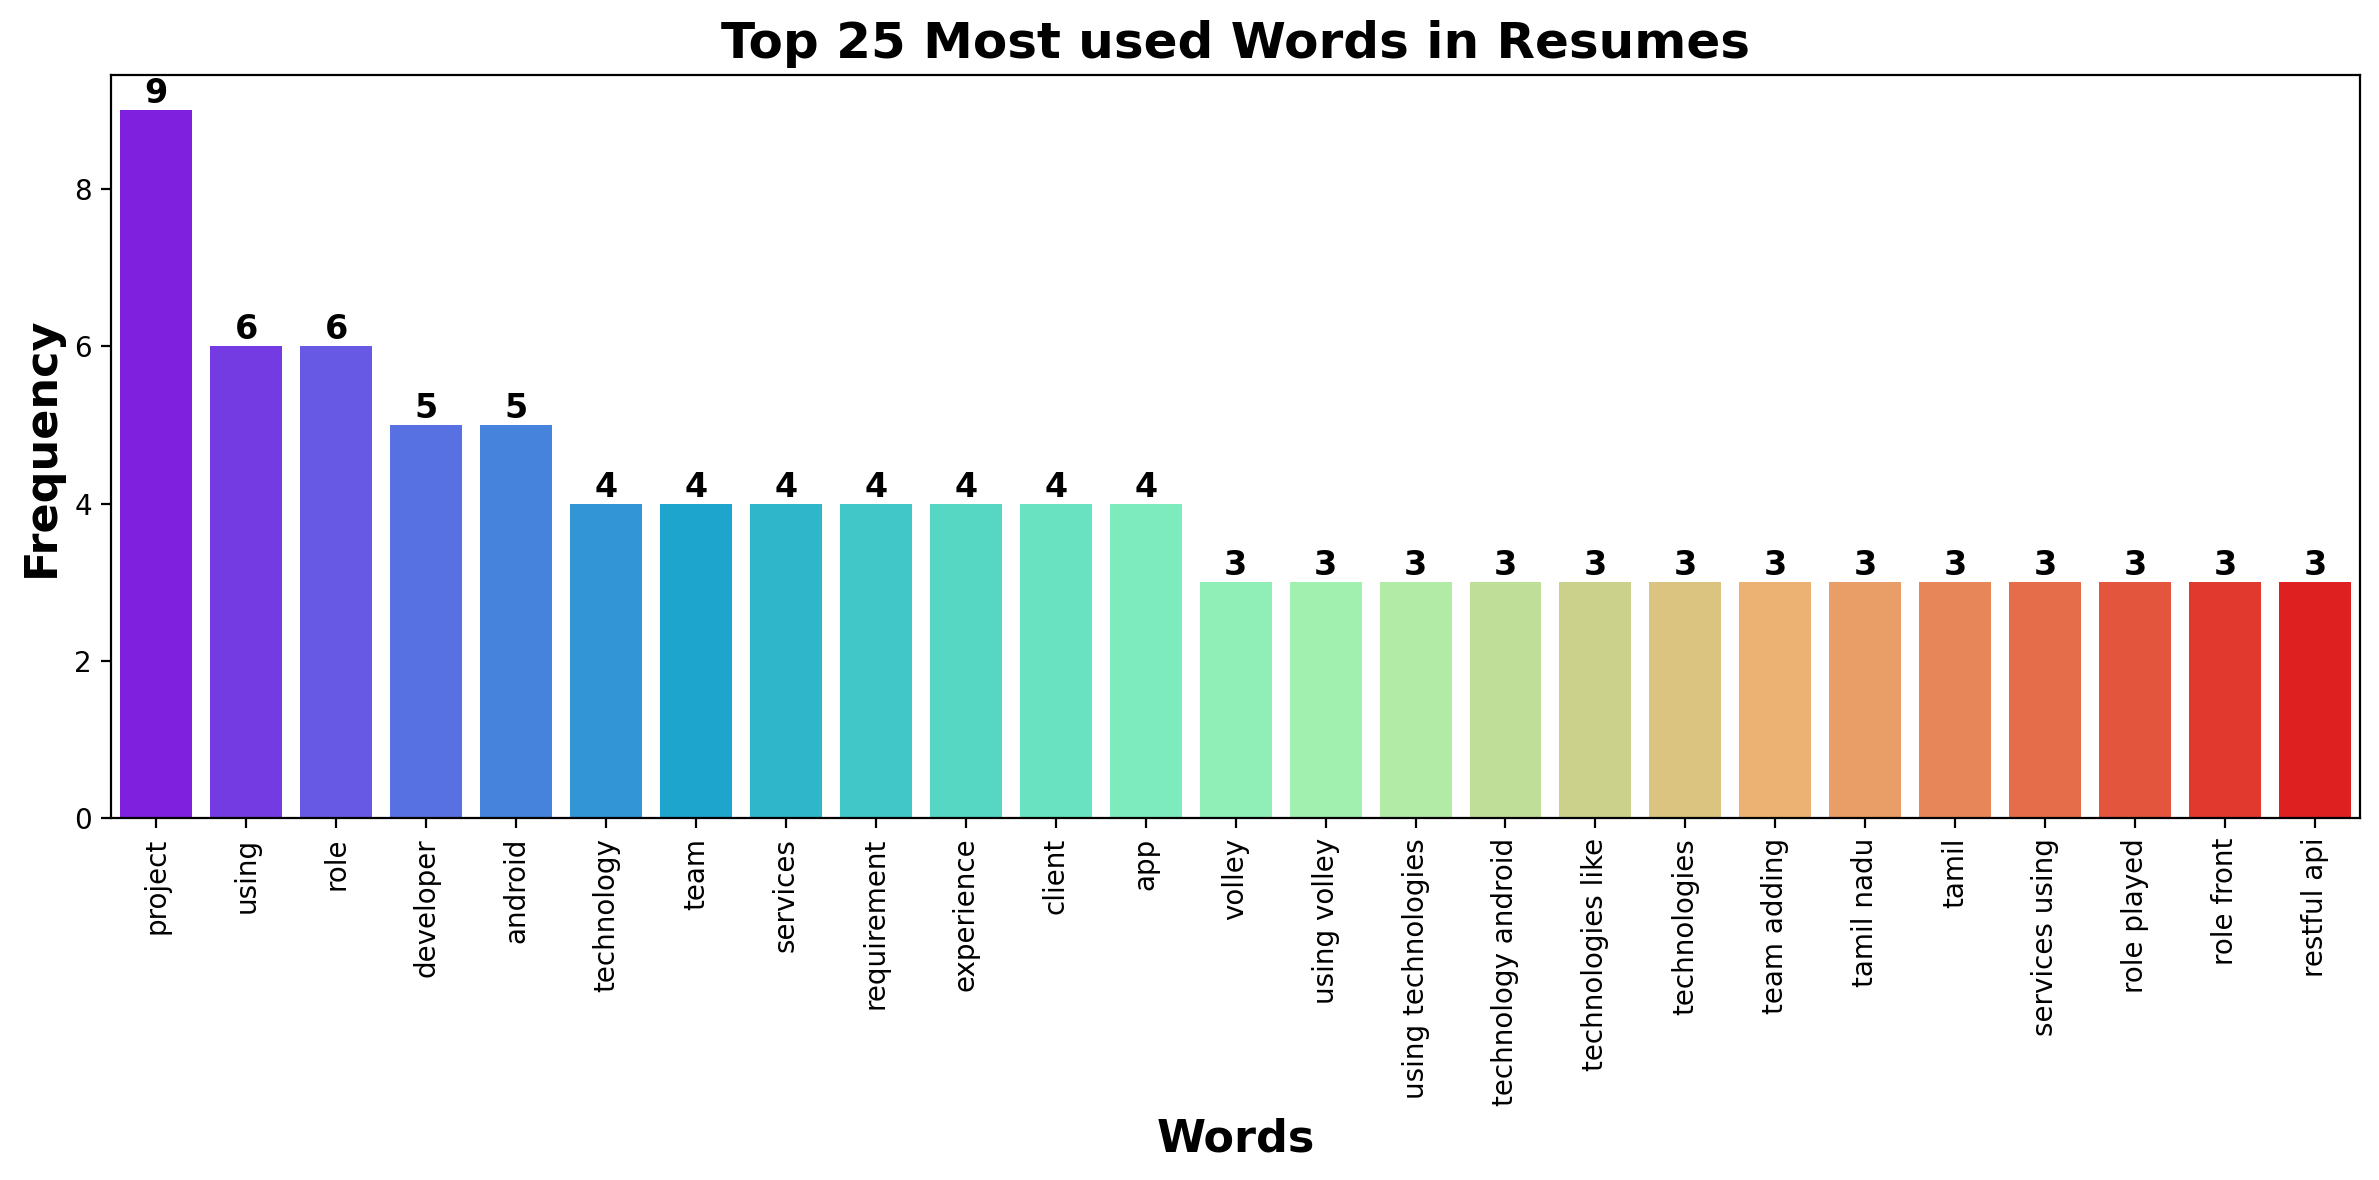

In [58]:
fig, axe = plt.subplots(1,1, figsize=(12,6), dpi=200)
colors = plt.cm.rainbow(np.linspace(0, 1, 25))
ax = sns.barplot(x=df_ngram['Unigram_Bigram'].head(25), y=df_ngram.Frequency.head(25), data=resume_data, ax = axe,
            label='Total Pofile Category : {}'.format(len(resume_data.folder.unique())),palette=colors )

axe.set_xlabel('Words', size=16,fontweight= 'bold')
axe.set_ylabel('Frequency', size=16, fontweight= 'bold')
plt.xticks(rotation = 90)
# plt.legend(loc='best', fontsize= 'x-large')
plt.title('Top 25 Most used Words in Resumes', fontsize= 18, fontweight= 'bold')
colors = plt.cm.rainbow(np.linspace(0, 1, len(x)))

for i in ax.containers:
    ax.bar_label(i,color = 'black', fontweight = 'bold', fontsize= 12)
# pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()


### 5.4 Using the Word Clowds

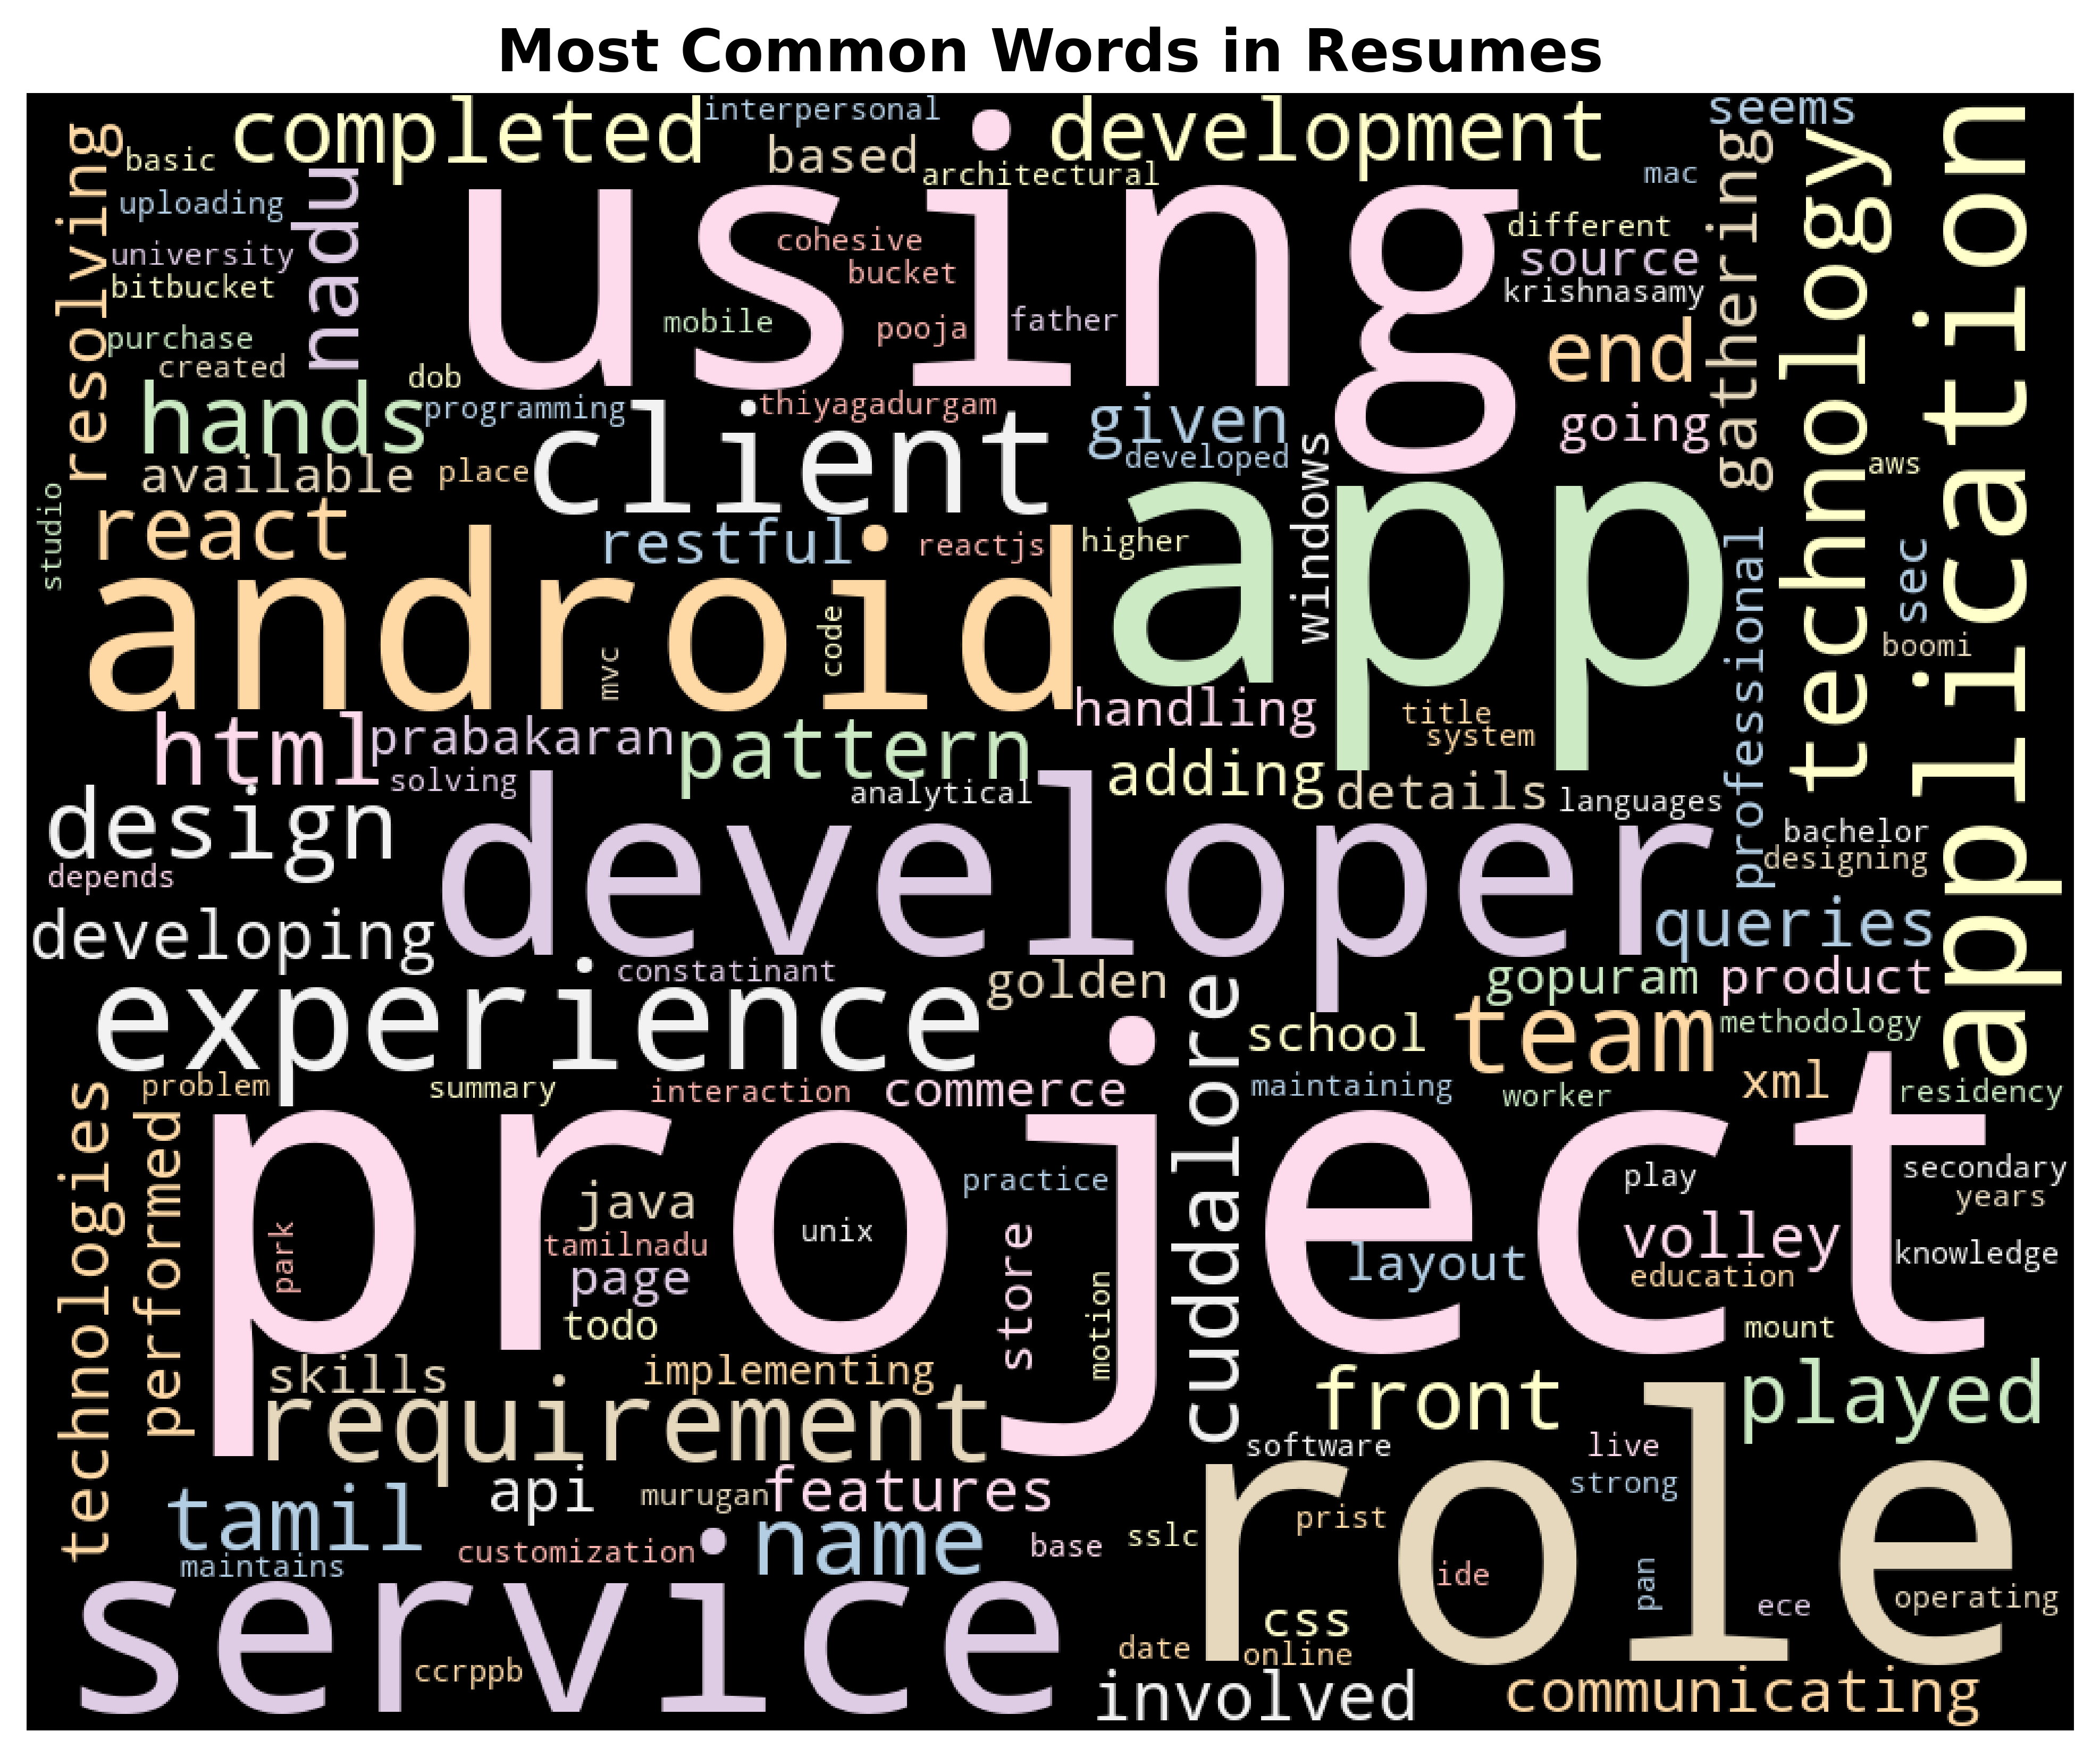

In [59]:
text = " ".join(cat for cat in resume_data.Resume_Details) # Creating the text variable

word_cloud = WordCloud(width=1000, height=800, random_state=10, background_color="black", 
                       colormap="Pastel1", collocations=False, stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10,8), dpi=500) # Display the generated Word Cloud
plt.title('Most Common Words in Resumes', fontsize= 16, fontweight= 'bold')
plt.imshow(word_cloud)
plt.axis("off")

# word_cloud.to_file('IMG/Word_Clowds.png')
plt.show()

# THE END !!